# 專題一: 使用 Monte Carlo Simulation 驗證 Jarque-Bera 檢定
# 說明: 在這份作品裡使用 Monte Carlo 方法來檢驗 JB 統計量的理論，同時對於該檢定在不同分配下的 power 進行驗證
# 目錄
## -- Part1: 驗證 Jarque-Bera statistics 其中 skewness 的部分
## -- Part2: 驗證 Jarque-Bera statistics 其中 kurtosis 的部分
## -- Part3: 驗證 Jarque-Bera statistics
## -- Part4: 檢驗在不同分配下 Jarque-Bera statistics 的檢定力

<hr>

In [3]:
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import chi2
from scipy.stats import t
from scipy.stats import uniform
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 程式說明
### 建立一個 function 將後面會檢驗的三種情況跟要繪製的圖同時放到 function 裡面，避免程式看起來過於冗長
### 在每次 monte carlo 中，固定模擬50000次，而圖中的n為每次模擬中所抽的樣本數
### 輸出中有兩張圖，第一張是模擬的值的histogram跟真實分布的pdf
### 第二張是模擬的值的ecdf跟真實值的cdf
<hr>

In [5]:
def plotting(n, param):

    data = norm.rvs(size = n * 10000).reshape(10000, n)
    x = np.linspace(-5, 5, 50)

    if param == "g1":
        skn = skew(data, axis = 1)
        static = np.sqrt(n / 6) * skn
        y = norm.pdf(x)
        cy = norm.cdf(x)
    elif param == "g2":
        kur = kurtosis(data, axis = 1, fisher = False)
        static = np.sqrt(n / 24) * (kur - 3)
        y = norm.pdf(x)
        cy = norm.cdf(x)
    elif param == "g3":
        skn = skew(data, axis = 1, bias = False)
        kur = kurtosis(data, axis = 1, fisher = False, bias = False)
        static = (n / 6) * (skn ** 2) + (n / 24) * ((kur - 3) ** 2)
        x = np.linspace(0, 20, 80)
        y = chi2.pdf(x, df = 2)
        cy = chi2.cdf(x, df = 2)
         
    cs = np.sort(static)
    cx = np.cumsum([1 / 10000] * 10000)
    

    fig, ax = plt.subplots(ncols = 2, figsize = [16, 6])
    ax[0].hist(static, bins = 80, alpha = 0.5, density = True)
    ax[0].plot(x, y)

    ax[1].step(cs, cx)
    ax[1].plot(x, cy)

    if param == "g1" or param == "g2":
        ax[0].set_xlim([-5, 5])
        ax[1].set_xlim([-5, 5])
    elif param == "g3":
        ax[0].set_xlim([0, 20])
        ax[1].set_xlim([0, 20])
    plt.suptitle(f"$n = {n}$", size = 35)
    plt.show()





# --Part1
# ------------------------------
## 驗證
## $$ G_1 = \sqrt{\frac{n}{6}} \hat{s} \rightarrow N(0, 1)$$
## 其中 $\hat{s}$ 為 skewness 的估計值

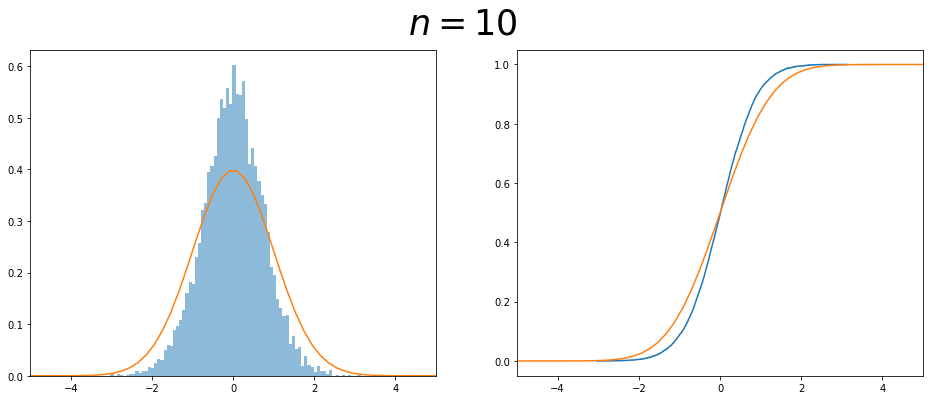

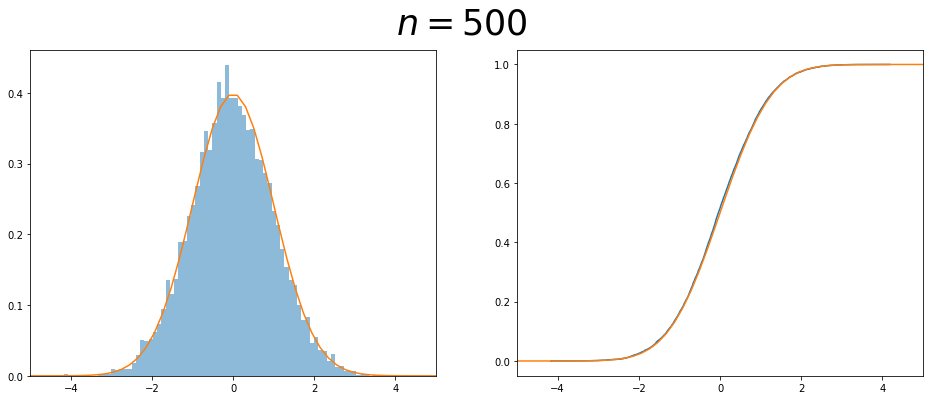

In [6]:
plotting(10, "g1")
plotting(500, "g1")

## 討論
### 當抽樣數為10時，可以發現近似效果已經不錯，沒有bias，只有scaling還有一些差距
### 當抽樣數為500時，可以看到 histogram 跟 ecdf 都非常接近 $N(0, 1)$ 的 pdf 和 cdf，驗證了這個理論


<hr>

# Part2
# --------------------
## 驗證

## $$ G_2 = \sqrt{\frac{n}{24}}(\hat{k} - 3)$$
## 其中 $\hat{k}$ 為 kurtosis 的估計值

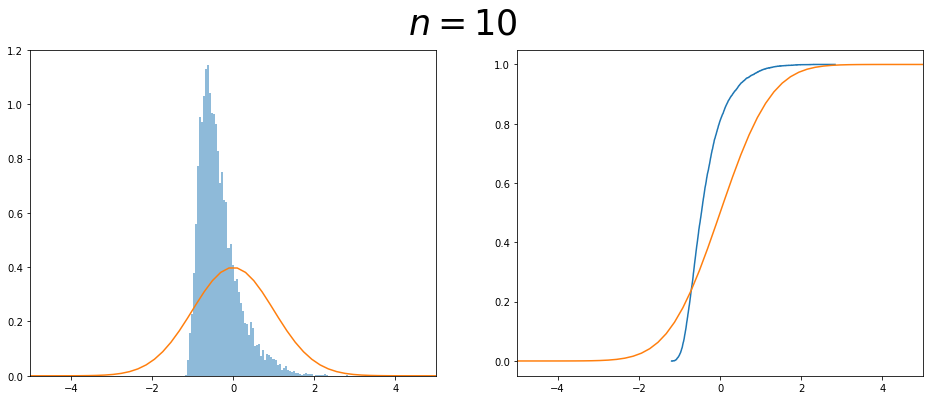

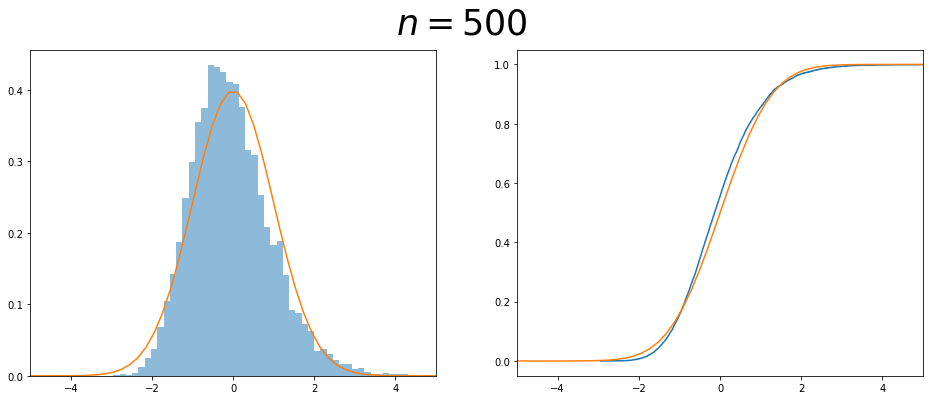

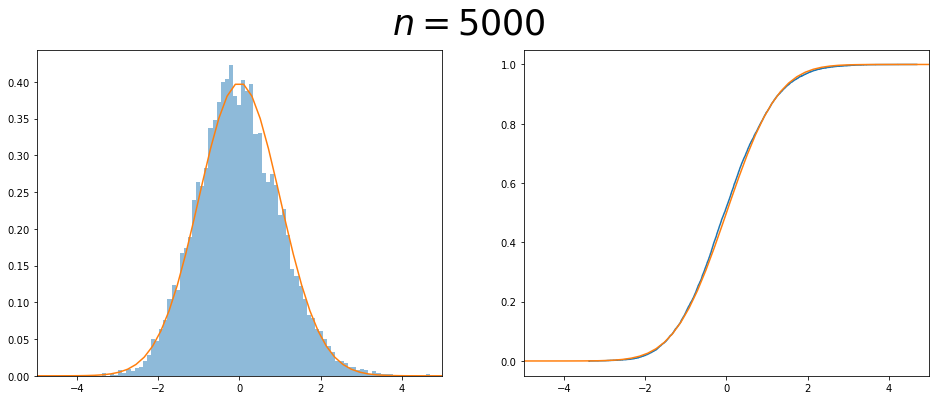

In [8]:
plotting(10, "g2")
plotting(500, "g2")
plotting(5000, "g2")

## 討論
### 可以看到 kurtosis 在小樣本的近似非常差，即使抽到 $n = 500$也都還明顯的有 bias
### 要一直抽到 $n = 5000$ 的時候才有顯著的近似
<hr>

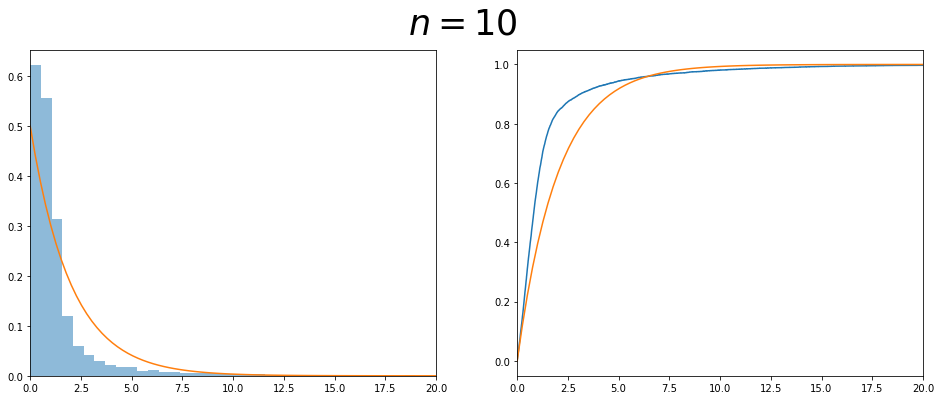

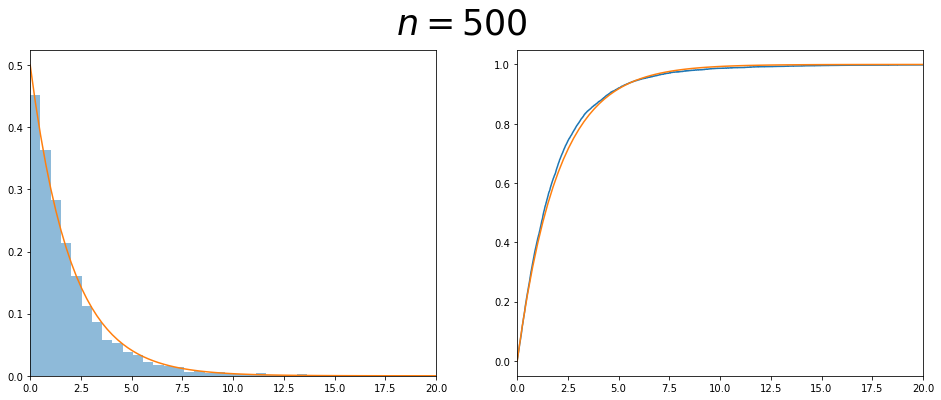

In [18]:
plotting(10, "g3")
plotting(500, "g3")

In [5]:
def JB_test(x):

    
    try:
        n = x.shape[1]
    except IndexError:
        x = np.tile(x, (1, 1))
        n = len(x)

    
    skn = skew(x, axis = 1)
    kur = kurtosis(x, fisher = False, axis = 1)
    static = (n / 6) * (skn ** 2) + (n / 24) * ((kur - 3) ** 2)
    pval = 1 - chi2.cdf(static, df = 2)
    output = {
        "statistic" : static,
        "p-value" : pval
    }
    return(output)

In [61]:
def power(x):
    pval = np.array(JB_test(x)["p-value"])
    estimated_power = (sum((pval < 0.05) * 1)) / 50000
    return(estimated_power)

plt.style.use("dark_background")

def function_select_and_plot(index, title, n = [10, 20, 30, 50, 100, 300, 500]):
    result = []
    if index == 1:
        for i in n:
            test = norm.rvs(size = i * 50000).reshape(50000, i)
            result.append(power(test))
    elif index == 2:
        for i in n:
            test = t.rvs(size = i * 50000, df = 3).reshape(50000, i)
            result.append(power(test))
    elif index == 3:
        for i in n:
            test = t.rvs(size = i * 50000, df = 10).reshape(50000, i)
            result.append(power(test))
    elif index == 4:
        for i in n:
                test = t.rvs(size = i * 50000, df = 30).reshape(50000, i)
                result.append(power(test))
    elif index == 5:
        for i in n:
                test = uniform.rvs(size = i * 50000, loc = 0, scale = 1).reshape(50000, i)
                result.append(power(test))
    elif index == 6:
        for i in n:
                test = chi2.rvs(size = i * 50000, df = 8).reshape(50000, i)
                result.append(power(test))

    x = np.arange(1, 8, 1)
    fig, ax = plt.subplots(figsize = [8, 6])
    ax.plot(x, result, marker = "o")
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in n])
    ax.set_title(f"power for JB-test when $H_a$ is {title}", size = 15)
 
    
    plt.show()       





$$N(0, 1)$$

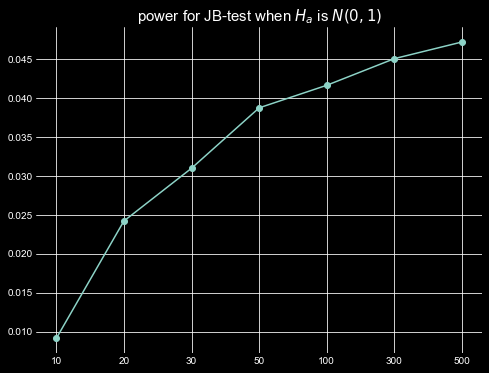

In [62]:
function_select_and_plot(1, "$N(0, 1)$")

$$T(3)$$

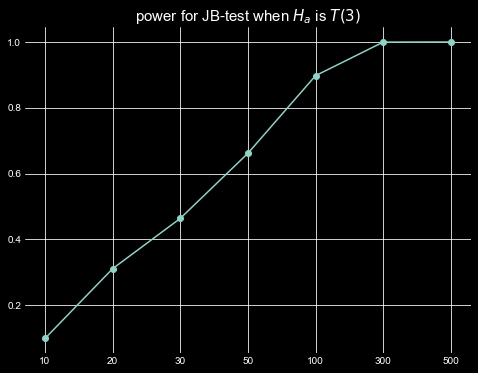

In [63]:
function_select_and_plot(2, "$T(3)$")

$$T(10)$$

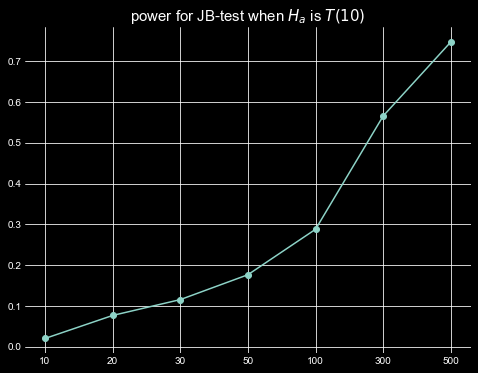

In [64]:
function_select_and_plot(3, "$T(10)$")

$$T(30)$$

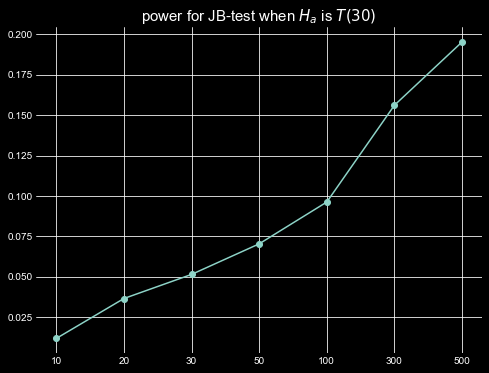

In [65]:
function_select_and_plot(4, "$T(30)$")

$$U(0, 1)$$

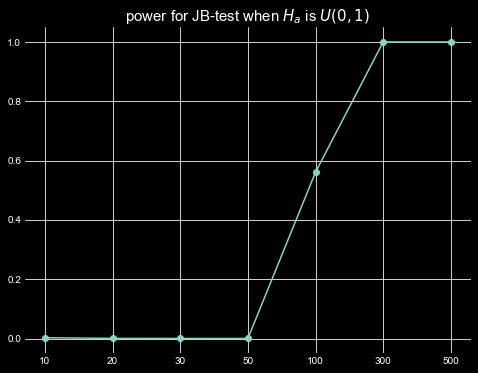

In [66]:
function_select_and_plot(5, "$U(0, 1)$")

$$\chi^2(8)$$

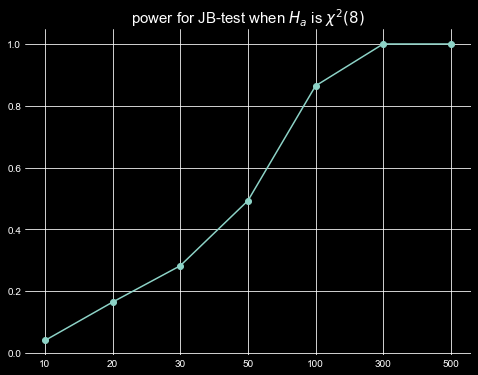

In [67]:
function_select_and_plot(6, "$\chi^2(8)$")